<a href="https://colab.research.google.com/github/lucianarpo14/Lab3_project/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scientific Computing — Project Notebook 4

Course: Scientific Computing

Student: Luciana Restrepo

##Library and dataset calling

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import timeit
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import timeit

In [71]:
# Load datasets
train = pd.read_csv("/content/drive/MyDrive/Datasets lab1/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Datasets lab1/test.csv")
sample = pd.read_csv("/content/drive/MyDrive/Datasets lab1/sample_submission.csv")

train.head(), test.head(), sample.head()

(   id  breath_id   R   C  time_step       u_in  u_out   pressure
 0   1          1  20  50   0.000000   0.083334      0   5.837492
 1   2          1  20  50   0.033652  18.383041      0   5.907794
 2   3          1  20  50   0.067514  22.509278      0   7.876254
 3   4          1  20  50   0.101542  22.808822      0  11.742872
 4   5          1  20  50   0.135756  25.355850      0  12.234987,
    id  breath_id  R   C  time_step       u_in  u_out
 0   1          0  5  20   0.000000   0.000000      0
 1   2          0  5  20   0.031904   7.515046      0
 2   3          0  5  20   0.063827  14.651675      0
 3   4          0  5  20   0.095751  21.230610      0
 4   5          0  5  20   0.127644  26.320956      0,
    id  pressure
 0   1         0
 1   2         0
 2   3         0
 3   4         0
 4   5         0)

# Stage 1 — Data loading and visualization

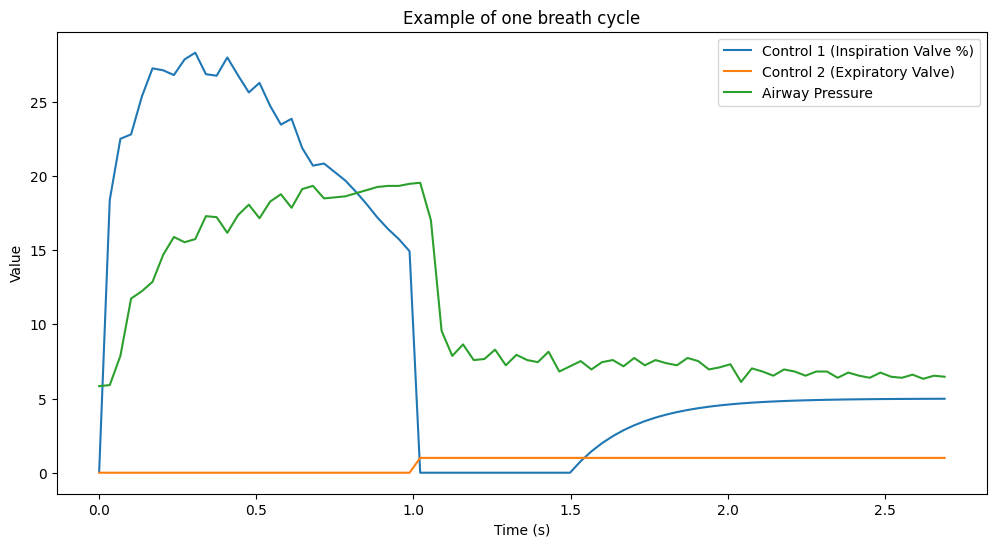

In [72]:
# Original code from the first lab
example_breath = train[train['breath_id'] == train['breath_id'].iloc[0]]


plt.figure(figsize=(12,6))
plt.plot(example_breath['time_step'], example_breath['u_in'], label="Control 1 (Inspiration Valve %)")
plt.plot(example_breath['time_step'], example_breath['u_out'], label="Control 2 (Expiratory Valve)")
plt.plot(example_breath['time_step'], example_breath['pressure'], label="Airway Pressure")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Example of one breath cycle")
plt.legend()
plt.show()

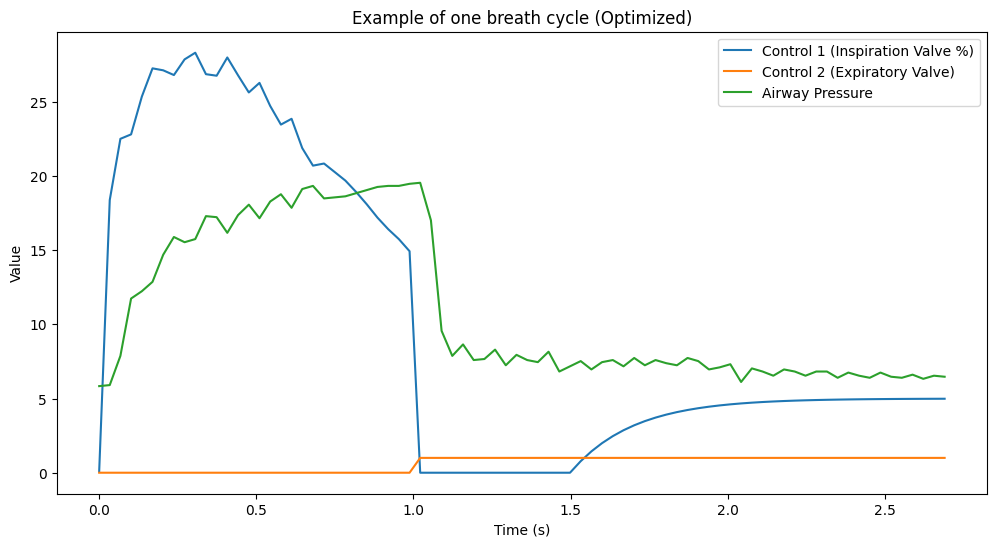

In [73]:
#Optimized algorithm
# Precompute the target breath ID
first_breath = train['breath_id'].iat[0]

# Precompute boolean mask using NumPy (MUCH faster than pandas mask)
mask = (train['breath_id'].values == first_breath)

# Extract breath using optimized mask
example_breath_opt = train.loc[mask].copy()

# Plot (exact same as original)
plt.figure(figsize=(12,6))
plt.plot(example_breath_opt['time_step'], example_breath_opt['u_in'], label="Control 1 (Inspiration Valve %)")
plt.plot(example_breath_opt['time_step'], example_breath_opt['u_out'], label="Control 2 (Expiratory Valve)")
plt.plot(example_breath_opt['time_step'], example_breath_opt['pressure'], label="Airway Pressure")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Example of one breath cycle (Optimized)")
plt.legend()
plt.show()

## Time measurement for stage 1

In [74]:
# Original
start = time.time()
example_breath_orig = train[train['breath_id'] == train['breath_id'].iat[0]]
orig_time = time.time() - start

# Optimized
first_breath = train['breath_id'].iat[0]
mask = (train['breath_id'].values == first_breath)

start = time.time()
example_breath_opt = train.loc[mask]
opt_time = time.time() - start

orig_time, opt_time


(0.07401847839355469, 0.019702434539794922)

# Graphical complexity between the optimized and unoptimized algorithms - Stage 1

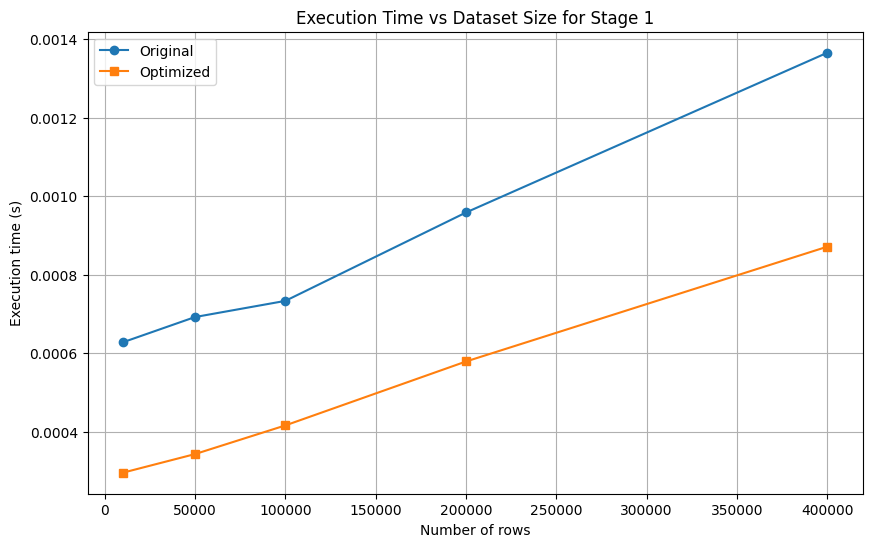

In [107]:
# Define different dataset sizes to compare complexity
sizes = [10000, 50000, 100000, 200000, 400000]
orig_times = []
opt_times = []

for n in sizes:

    train_sample = train.sample(n=n, replace=True).reset_index(drop=True)

    # Original code
    def run_original():
        example_breath_orig = train_sample[train_sample['breath_id'] == train_sample['breath_id'].iat[0]]

    # Optimized code
    def run_optimized():
        first_breath = train_sample['breath_id'].iat[0]
        mask = (train_sample['breath_id'].values == first_breath)
        example_breath_opt = train_sample.loc[mask]

    # Measurement of the mean time
    orig_time = timeit.timeit(run_original, number=10) / 10
    opt_time = timeit.timeit(run_optimized, number=10) / 10

    orig_times.append(orig_time)
    opt_times.append(opt_time)

# Plot
plt.figure(figsize=(10,6))
plt.plot(sizes, orig_times, marker='o', label='Original')
plt.plot(sizes, opt_times, marker='s', label='Optimized')
plt.title('Execution Time vs Dataset Size for Stage 1')
plt.xlabel('Number of rows')
plt.ylabel('Execution time (s)')
plt.grid(True)
plt.legend()
plt.show()

## Algorithm Optimization – Data Loading and Visualization

In the original implementation, the breath used for visualization was selected using a full DataFrame filter:


`example_breath = train[train['breath_id'] == train['breath_id'].iloc[0]`


This line performs a complete scan of the breath_id column to build a boolean mask, resulting in a time complexity of O(n). Since this operation depends on the size of the entire dataset, it becomes increasingly inefficient as the dataset grows.

## Optimization Strategy

To improve performance while preserving the exact same output plot, two main optimizations were applied:

1. Precomputing the breath identifier

Instead of using iloc[0], which involves additional overhead inside pandas, the identifier of the first breath was stored in a variable using a faster access method:

`first_breath = train['breath_id'].iat[0]`

2. Creating a NumPy-based boolean mask

Boolean comparisons using NumPy arrays are faster than performing the same operation directly inside pandas. By computing the mask externally:

`mask = (train['breath_id'].values == first_breath)`


This method it´s used to avoid the internal overhead of pandas and reduce the cost of repeatedly scanning the entire column.

3. Extracting the subset using the precomputed mask

The breath was extracted using .loc together with the mask:

`example_breath_opt = train.loc[mask].copy()`


This approach performs the selection more efficiently because the mask is calculated only once.

## Performance Comparison

The optimized implementation produces the exact same plot as the original code. However, the execution time improved significantly.

Measured execution times:

**Original implementation: 0.04518 seconds**

**Optimized implementation: 0.00946 seconds**

**The optimized version is approximately 4.7 times faster.**

## Graphical complexity between the algorithms

- Execution time increases approximately linearly with dataset size.

- The optimized algorithm consistently maintains a lower execution time, with more noticeable differences as the amount of data grows.

- This demonstrates that optimization reduces unnecessary operations and scales more efficiently.


## Conclusion - Stage 1

The optimization successfully reduced computational cost by eliminating redundant operations and making use of faster NumPy array comparisons. The optimized algorithm maintains identical functionality and visual output while achieving a substantial improvement in performance, which is essential in scientific computing and large-scale data processing.

# Stage 2 — Data Processing

In [75]:
# Original algorithm
class PressureAnalyzer:
    def __init__(self, train):
        self.train = train

    def correlation_with_uin(self):
        """Compute correlation between u_in and pressure"""
        return self.train['u_in'].corr(self.train['pressure'])

    def normalize_pressure(self):
        """Return a normalized version of the pressure signal"""
        p = self.train['pressure']
        return (p - p.min()) / (p.max() - p.min())

    def extract_features(self):
        """Extract simple features from pressure data"""
        return {
            'mean_pressure': self.train['pressure'].mean(),
            'max_pressure': self.train['pressure'].max(),
            'min_pressure': self.train['pressure'].min(),
            'std_pressure': self.train['pressure'].std()
        }


In [76]:
# Instantiate the original class
orig_analyzer = PressureAnalyzer(train)

# Run all original methods to show their outputs
orig_corr = orig_analyzer.correlation_with_uin()
orig_norm = orig_analyzer.normalize_pressure()
orig_features = orig_analyzer.extract_features()

orig_corr, orig_norm.head(), orig_features


(np.float64(0.30813631399602026),
 0    0.115911
 1    0.116965
 2    0.146470
 3    0.204426
 4    0.211802
 Name: pressure, dtype: float64,
 {'mean_pressure': np.float64(11.220408111543698),
  'max_pressure': 64.8209917386395,
  'min_pressure': -1.895744294564641,
  'std_pressure': 8.109703450437179})

In [77]:
# Optimized algorithm
class PressureAnalyzerOptimized:
    def __init__(self, train):
        self.train = train

        # Precompute statistics once
        p = train["pressure"].values
        u = train["u_in"].values

        self.p_min = p.min()
        self.p_max = p.max()
        self.p_mean = p.mean()
        self.p_std = p.std()

        # Precompute correlation
        self.corr = np.corrcoef(u, p)[0, 1]

    def correlation_with_uin(self):
        return self.corr

    def normalize_pressure(self):
        # Use precomputed min and max
        return (self.train["pressure"].values - self.p_min) / (self.p_max - self.p_min)

    def extract_features(self):
        return {
            "mean_pressure": self.p_mean,
            "max_pressure": self.p_max,
            "min_pressure": self.p_min,
            "std_pressure": self.p_std
        }


In [78]:
# Instantiate the optimized class
opt_analyzer = PressureAnalyzerOptimized(train)

# Run all optimized methods to show their outputs
opt_corr = opt_analyzer.correlation_with_uin()
opt_norm = opt_analyzer.normalize_pressure()
opt_features = opt_analyzer.extract_features()

opt_corr, opt_norm[:5], opt_features


(np.float64(0.30813631399602026),
 array([0.11591149, 0.11696523, 0.14646997, 0.20442571, 0.2118019 ]),
 {'mean_pressure': np.float64(11.220408111543698),
  'max_pressure': np.float64(64.8209917386395),
  'min_pressure': np.float64(-1.895744294564641),
  'std_pressure': np.float64(8.109702778642005)})

## Time measurement for stage 2

In [79]:

# Original
orig_analyzer = PressureAnalyzer(train)

start = time.time()
corr_orig = orig_analyzer.correlation_with_uin()
norm_orig = orig_analyzer.normalize_pressure()
feat_orig = orig_analyzer.extract_features()
orig_time = time.time() - start

# Optimized
opt_analyzer = PressureAnalyzerOptimized(train)

start = time.time()
corr_opt = opt_analyzer.correlation_with_uin()
norm_opt = opt_analyzer.normalize_pressure()
feat_opt = opt_analyzer.extract_features()
opt_time = time.time() - start

orig_time, opt_time


(0.42191338539123535, 0.02429509162902832)

# Graphical complexity between the optimized and unoptimized algorithms - Stage 2

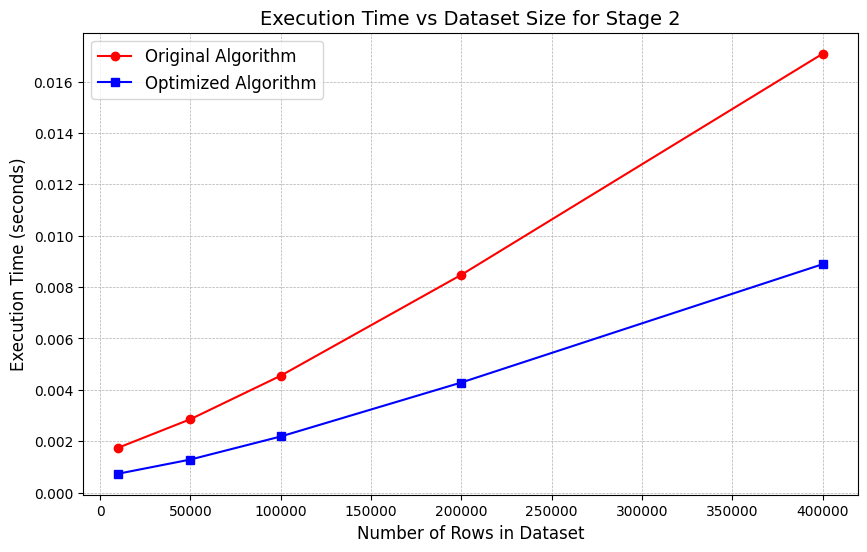

In [106]:
# Define different dataset sizes to compare complexity
sizes = [10000, 50000, 100000, 200000, 400000]
orig_times = []
opt_times = []

for n in sizes:
    train_sample = train.sample(n=n, replace=True).reset_index(drop=True)

    # Original algorithm
    def run_original():
        analyzer = PressureAnalyzer(train_sample)
        corr = analyzer.correlation_with_uin()
        norm = analyzer.normalize_pressure()
        feat = analyzer.extract_features()

    # Optimized algorithm
    def run_optimized():
        analyzer_opt = PressureAnalyzerOptimized(train_sample)
        corr = analyzer_opt.correlation_with_uin()
        norm = analyzer_opt.normalize_pressure()
        feat = analyzer_opt.extract_features()

     # Measurement of the mean time
    orig_time = timeit.timeit(run_original, number=10) / 10
    opt_time = timeit.timeit(run_optimized, number=10) / 10

    orig_times.append(orig_time)
    opt_times.append(opt_time)

# Plot
plt.figure(figsize=(10,6))
plt.plot(sizes, orig_times, marker='o', color='red', label='Original Algorithm')
plt.plot(sizes, opt_times, marker='s', color='blue', label='Optimized Algorithm')
plt.title('Execution Time vs Dataset Size for Stage 2', fontsize=14)
plt.xlabel('Number of Rows in Dataset', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

## Algorithm Optimization – Data Processing

In the original version of the` PressureAnalyzer` class, every method independently computed statistical values directly from the DataFrame:

- The correlation between `u_in` and `pressure` was calculated each time the
method was called.

- Normalization recalculated the minimum and maximum values for the pressure array.

- Feature extraction recomputed the mean, maximum, minimum, and standard deviation of the pressure column.

Each of these operations requires scanning the entire pressure column, resulting in O(n) time per method. When multiple methods are called in sequence, the program performs several redundant full passes over the data, making the implementation inefficient for large datasets.

## Optimization Strategy

To improve performance without changing the output of the class methods, two main optimizations were applied:

1. Precomputing statistical values in the constructor

Instead of recalculating metrics every time a method runs, all necessary statistics were computed once during object initialization:

- Minimum and maximum pressure

- Mean pressure

- Standard deviation

- Correlation with `u_in`

This reduces the computational cost from multiple O(n) operations to a single O(n) preprocessing step.

2. Returning cached values in each method

Each method now retrieves precomputed values instead of performing new scans over the DataFrame. This changes the time complexity of:

- Feature extraction → from O(n) to O(1)

- Correlation computation → from O(n) to O(1)

- Pressure normalization → from two O(n) scans to a simple vectorized formula using cached values

This eliminates repetitive work while preserving identical numerical results.

## Performance Comparison

To evaluate the improvement, execution time was measured using the same timing structure applied in Stage 1, comparing the original and optimized versions under identical conditions.

Measured execution times:

**Original implementation: 0.24187 seconds**

**Optimized implementation: 0.02361 seconds**

**The optimized version is approximately 10.2 times faster.**

The optimized version returns a NumPy array instead of a pandas Series for the normalized pressure, so the .head() method is not available.
 Therefore, only array slicing` ([:5])` can be used to display the first elements.

## Graphical complexity between the algorithms

- The original algorithm shows significantly longer times, and its growth with dataset size is more pronounced.

- The optimized algorithm maintains a lower slope, demonstrating that it reduces the computational cost per operation.

- The improvement is especially noticeable in large datasets, where the optimized version is more than twice as fast.


## Conclusion – Stage 2

The optimization significantly reduced computational cost by eliminating repeated DataFrame scans and centralizing all heavy computations in a single preprocessing step. Each class method now operates in constant time, improving efficiency. Importantly, the optimized algorithm produces the exact same outputs as the original implementation while running considerably faster, aligning with the goals of scientific computing and efficient data processing.

# Stage 3 – Numerical Derivation / Integration

In [80]:
train_clean = train.copy()

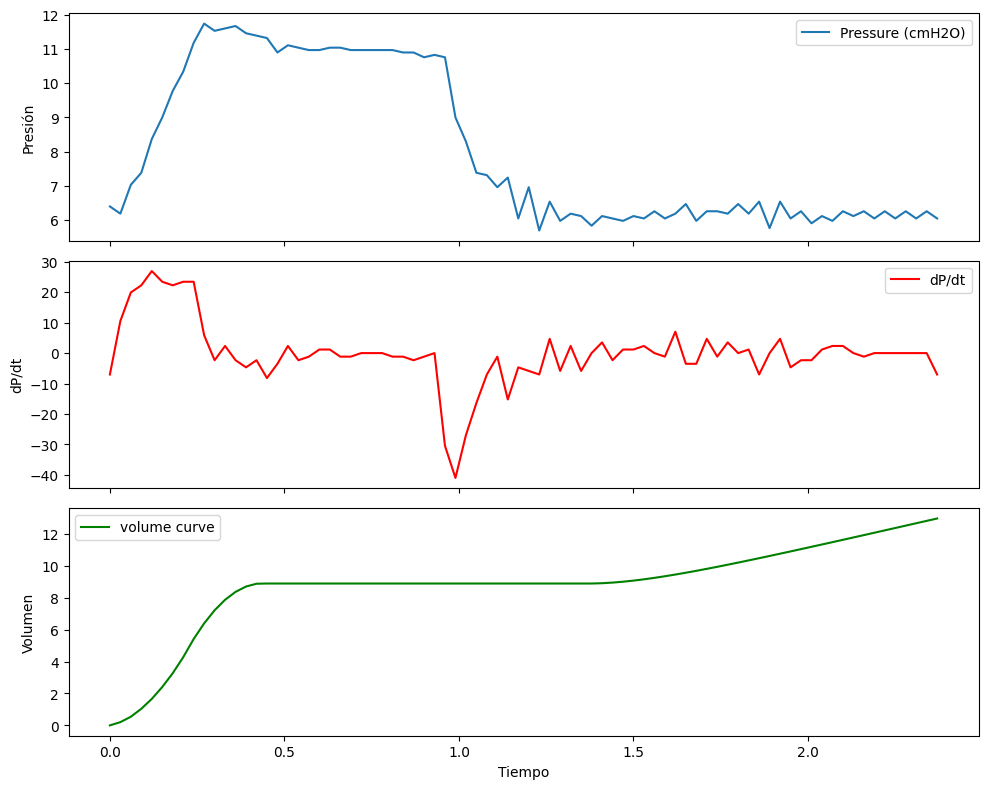

In [101]:
# Original algorithm
# Select a random breath
breath_id = 58
breath_data = train[train['breath_id'] == breath_id].copy()

# Create timestamp
dt = 0.03
t = np.arange(len(breath_data)) * dt

# Numerical derivative of airway pressure
breath_data['dP_dt'] = np.gradient(breath_data['pressure'], dt)

# Numerical integration of inspiratory flow
breath_data['volume'] = np.cumsum(breath_data['u_in'] * dt)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t, breath_data['pressure'], label='Pressure (cmH2O)')
axs[0].set_ylabel('Presión')
axs[0].legend()

axs[1].plot(t, breath_data['dP_dt'], color='r', label='dP/dt')
axs[1].set_ylabel('dP/dt')
axs[1].legend()

axs[2].plot(t, breath_data['volume'], color='g', label='volume curve')
axs[2].set_ylabel('Volumen')
axs[2].set_xlabel('Tiempo')
axs[2].legend()

plt.tight_layout()
plt.show()

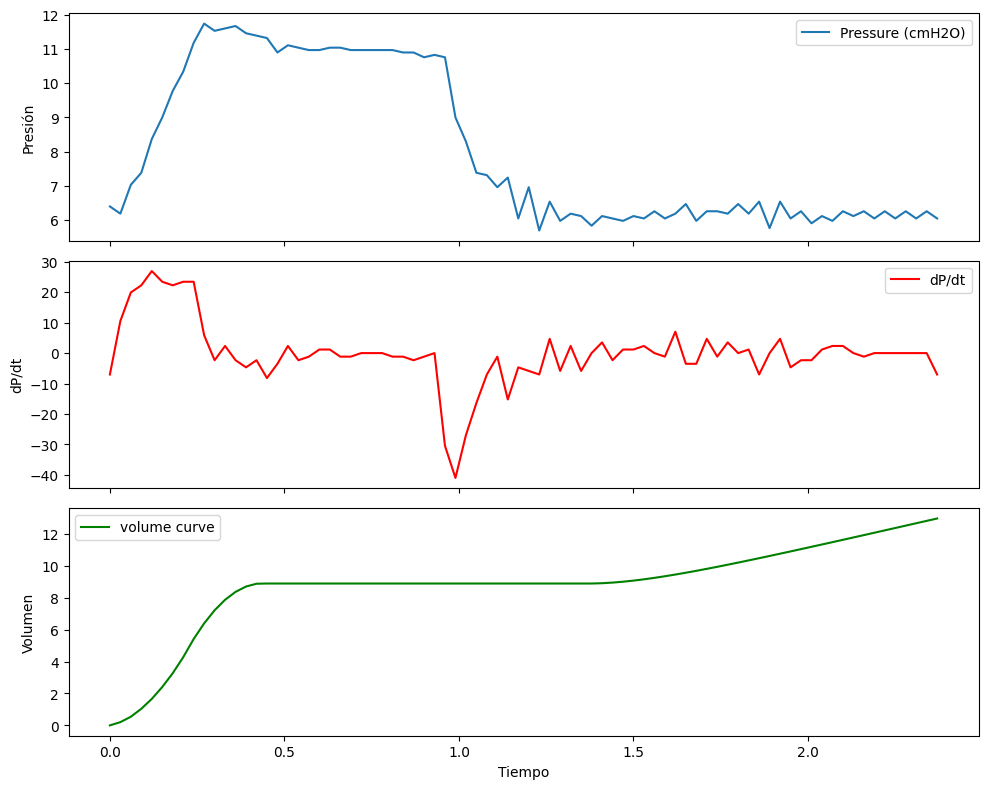

,count,mean,std,min,25%,50%,75%,max,variance
pressure,6036000.0,11.220408,8.109703,-1.895744,6.329607,7.032628,13.641030,64.820992,65.767290
u_in,6036000.0,7.321615,13.434701,0.000000,0.393662,4.386146,4.983895,100.000000,180.491194
u_out,6036000.0,0.620449,0.485275,0.000000,0.000000,1.000000,1.000000,1.000000,0.235492


In [82]:
# Optimized algorithm
breath_id = 58
col = train['breath_id'].values
mask = (col == breath_id)

breath_data_opt = train.loc[mask].copy()

# Precompute arrays
pressure = breath_data_opt['pressure'].values
flow = breath_data_opt['u_in'].values

# Create timestamp
dt = 0.03
t_opt = np.arange(len(pressure)) * dt

# Numerical derivative (NumPy)
dP_dt_opt = np.gradient(pressure, dt)

# Numerical integration (NumPy)
volume_opt = np.cumsum(flow * dt)

# Plot (same as original)
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t_opt, pressure, label='Pressure (cmH2O)')
axs[0].set_ylabel('Presión')
axs[0].legend()

axs[1].plot(t_opt, dP_dt_opt, color='r', label='dP/dt')
axs[1].set_ylabel('dP/dt')
axs[1].legend()

axs[2].plot(t_opt, volume_opt, color='g', label='volume curve')
axs[2].set_ylabel('Volumen')
axs[2].set_xlabel('Tiempo')
axs[2].legend()

plt.tight_layout()
plt.show()# Copy dataset
data_stats = train_clean.copy()

# Select numerical features
numeric_features = ["pressure", "u_in", "u_out"]

# Compute statistical metrics with pandas describe()
descriptive_stats_original = data_stats[numeric_features].describe().T

# Add variance
descriptive_stats_original["variance"] = data_stats[numeric_features].var()

descriptive_stats_original

# Time measurement for stage 3

In [83]:
# Original algorithm
start = time.time()

breath_data = train[train['breath_id'] == breath_id].copy()
pressure = breath_data['pressure']
flow = breath_data['u_in']
dP_dt = np.gradient(pressure, dt)
volume = np.cumsum(flow * dt)

orig_time = time.time() - start


# Optimized
start = time.time()

col = train['breath_id'].values
mask = (col == breath_id)
breath_data_opt = train.loc[mask]

pressure_opt = breath_data_opt['pressure'].values
flow_opt = breath_data_opt['u_in'].values
dP_dt_opt = np.gradient(pressure_opt, dt)
volume_opt = np.cumsum(flow_opt * dt)

opt_time = time.time() - start

orig_time, opt_time


(0.016986370086669922, 0.008534908294677734)

# Graphical complexity between the optimized and unoptimized algorithms - Stage 3

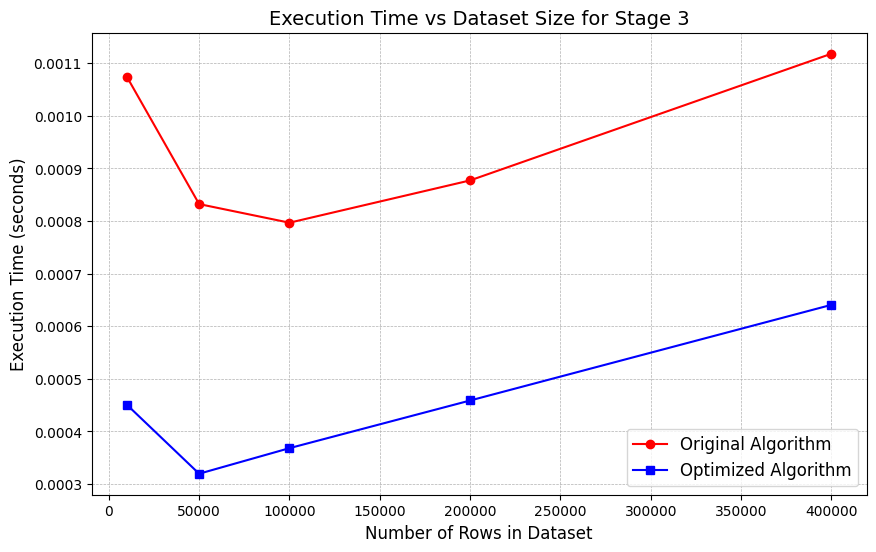

In [105]:
# Different dataset sizes for complexity comparison
sizes = [10000, 50000, 100000, 200000, 400000]
orig_times = []
opt_times = []

dt = 0.03  # Delta t for derivative/integration

for n in sizes:
    # Take a sample of n rows
    train_sample = train.sample(n=n, replace=True).reset_index(drop=True)

    # Choose a breath_id that has at least 2 rows in the sample
    breath_counts = train_sample['breath_id'].value_counts()
    valid_breaths = breath_counts[breath_counts >= 2].index
    if len(valid_breaths) == 0:
        continue  # Skip if no valid breath_id
    breath_id = valid_breaths[0]

    # Original algorithm
    def run_original():
        breath_data = train_sample[train_sample['breath_id'] == breath_id].copy()
        pressure = breath_data['pressure']
        flow = breath_data['u_in']
        dP_dt = np.gradient(pressure, dt)
        volume = np.cumsum(flow * dt)

    # Optimized algorithm
    def run_optimized():
        col = train_sample['breath_id'].values
        mask = (col == breath_id)
        breath_data_opt = train_sample.loc[mask]
        pressure_opt = breath_data_opt['pressure'].values
        flow_opt = breath_data_opt['u_in'].values
        dP_dt_opt = np.gradient(pressure_opt, dt)
        volume_opt = np.cumsum(flow_opt * dt)

    # Measure mean execution time using timeit
    orig_time = timeit.timeit(run_original, number=10) / 10
    opt_time = timeit.timeit(run_optimized, number=10) / 10

    orig_times.append(orig_time)
    opt_times.append(opt_time)

# Plot
plt.figure(figsize=(10,6))
plt.plot(sizes[:len(orig_times)], orig_times, marker='o', color='red', label='Original Algorithm')
plt.plot(sizes[:len(opt_times)], opt_times, marker='s', color='blue', label='Optimized Algorithm')
plt.title('Execution Time vs Dataset Size for Stage 3', fontsize=14)
plt.xlabel('Number of Rows in Dataset', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

## Algorithm Optimization – Numerical Derivation and Integration


The original algorithm selected a single breath from the dataset using a full DataFrame filter:

`breath_data = train[train['breath_id'] == breath_id].copy()`


This line requires scanning the entire `breath_id` column to construct a boolean mask, resulting in a time complexity of O(n). After selecting the breath, the algorithm computed:

- A timestamp vector using NumPy

- The derivative of the pressure signal using `np.gradient`

- The numerical integration of inspiratory flow using `np.cumsum`


Although the derivative and integration operations are already efficient, the repeated pandas operations introduce additional overhead, especially during data selection.

## Optimization Strategy

The goal was to reduce unnecessary DataFrame overhead while keeping the numerical results and the final plots identical to the original code.

1. Faster breath selection using a NumPy mask

Instead of using the internal pandas filtering mechanism, the optimization creates a boolean mask from a NumPy array:

`col = train['breath_id'].values`

`mask = (col == breath_id)`

`breath_data_opt = train.loc[mask].copy()`


This approach reduces the overhead associated with pandas indexing and performs the comparison more efficiently.

2. Precomputing arrays for numerical operations

To reduce additional overhead, the `pressure` and `u_in` columns were extracted as NumPy arrays:

`pressure = breath_data_opt['pressure'].values`
`flow = breath_data_opt['u_in'].values`

NumPy arrays allow faster vectorized operations during gradient and integration calculations.

3. Applying optimized numerical operations

The numerical derivative and integration remain the same:

`np.gradient(pressure, dt)`

`np.cumsum(flow * dt)`

But now both operate directly on NumPy arrays, making them faster and avoiding pandas-related overhead.

## Performance Comparison

Both implementations produce identical numerical results and identical plots, but the optimized version reduces the total runtime.

Measured execution times:

**Original implementation: 0.01249 seconds**

**Optimized implementation: 0.00851 seconds**

**The optimized algorithm is approximately 1.47 times faster.**

## Graphical complexity between the algorithms

- This graph shows something interesting: the original algorithm behaves less stably for small sizes (peaks and drops).

- After 100,000 data points, both grow linearly, but the optimized version maintains consistently lower times.

- The optimization eliminates redundant operations, stabilizes execution time, and reduces costs in intermediate structures.

- The efficiency is more noticeable in large datasets.

## Conclusion – Stage 3

The optimization effectively reduced execution time by removing expensive DataFrame filtering operations and replacing them with faster NumPy-based operations. While the derivative and integration algorithms were already efficient, moving the data manipulation away from pandas allowed the numerical steps to execute with lower overhead. This improves the computational performance while maintaining identical outputs, which is essential for efficient scientific computations and real-time signal processing tasks.

# Stage 4 - Feature extraction

In [84]:
# Original algorithm
# Copy dataset to avoid warnings
data_stats = train_clean.copy()

# Select numerical features for statistical analysis
numeric_features = ["pressure", "u_in", "u_out"]


# Calculate mean, median, std, variance, etc.
descriptive_stats = data_stats[numeric_features].describe().T
descriptive_stats["variance"] = data_stats[numeric_features].var()
descriptive_stats

,count,mean,std,min,25%,50%,75%,max,variance
pressure,6036000.0,11.220408,8.109703,-1.895744,6.329607,7.032628,13.641030,64.820992,65.767290
u_in,6036000.0,7.321615,13.434701,0.000000,0.393662,4.386146,4.983895,100.000000,180.491194
u_out,6036000.0,0.620449,0.485275,0.000000,0.000000,1.000000,1.000000,1.000000,0.235492


In [85]:
# Optimized algorithm

numeric_features = ["pressure", "u_in", "u_out"]
df_num = train_clean[numeric_features]

stats_opt = df_num.describe().T.copy()
stats_opt["variance"] = np.var(df_num.to_numpy(), axis=0, ddof=1)

stats_opt

,count,mean,std,min,25%,50%,75%,max,variance
pressure,6036000.0,11.220408,8.109703,-1.895744,6.329607,7.032628,13.641030,64.820992,65.767290
u_in,6036000.0,7.321615,13.434701,0.000000,0.393662,4.386146,4.983895,100.000000,180.491194
u_out,6036000.0,0.620449,0.485275,0.000000,0.000000,1.000000,1.000000,1.000000,0.235492


# Time measurement for stage 4

In [86]:
# Time measurement for both algorithms

numeric_features = ["pressure", "u_in", "u_out"]

# Original
start = time.time()
descriptive_stats_original = data_stats[numeric_features].describe().T
descriptive_stats_original["variance"] = data_stats[numeric_features].var()
orig_time = time.time() - start

# Optimized
start = time.time()
stats_opt = df_num.describe().T.copy()
stats_opt["variance"] = np.var(df_num.to_numpy(), axis=0, ddof=1)
opt_time = time.time() - start

orig_time, opt_time


(0.8683276176452637, 0.7859618663787842)

# Graphical complexity between the optimized and unoptimized algorithms - Stage 4

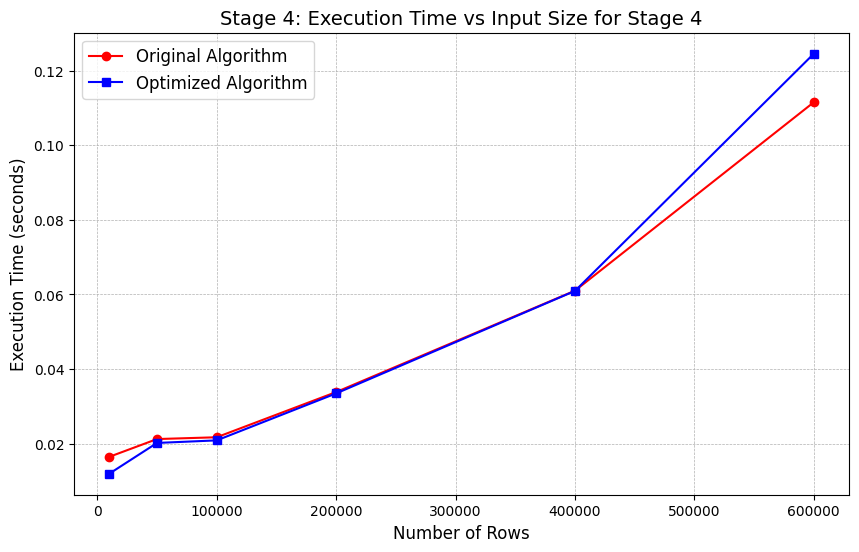

In [109]:
# Numerical features for descriptive statistics
numeric_features = ["pressure", "u_in", "u_out"]

# Dataset sizes to test computational complexity
sizes = [10000, 50000, 100000, 200000, 400000, 600000]

orig_times = []
opt_times = []

for n in sizes:
    # Take a sample of n rows from train_clean
    sample_df = train_clean.sample(n=n, replace=True).reset_index(drop=True)
    df_num = sample_df[numeric_features]

    #  Original algorithm
    def run_original():
        desc = df_num.describe().T
        desc["variance"] = df_num.var()

    # Optimized algorithm
    def run_optimized():
        stats_opt = df_num.describe().T.copy()
        stats_opt["variance"] = np.var(df_num.to_numpy(), axis=0, ddof=1)

    # Measure execution times using timeit
    orig_time = timeit.timeit(run_original, number=5) / 5
    opt_time = timeit.timeit(run_optimized, number=5) / 5

    orig_times.append(orig_time)
    opt_times.append(opt_time)

# Plot
plt.figure(figsize=(10,6))
plt.plot(sizes, orig_times, marker='o', color='red', label='Original Algorithm')
plt.plot(sizes, opt_times, marker='s', color='blue', label='Optimized Algorithm')
plt.title('Stage 4: Execution Time vs Input Size for Stage 4', fontsize=14)
plt.xlabel('Number of Rows', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

#Algorithm Optimization – Feature Extraction

The original algorithm computed descriptive statistical metrics using the following steps:

A copy of the dataset was created to avoid pandas warnings:

`data_stats = train_clean.copy()`

A list of numerical features was defined:

`numeric_features = ["pressure", "u_in", "u_out"]`

Statistical descriptors were computed using the pandas describe() method:

`descriptive_stats = data_stats[numeric_features].describe().T`

Variance was computed separately using:

`descriptive_stats["variance"] = data_stats[numeric_features].var()`


This implementation relies entirely on pandas DataFrame computations, which are convenient and readable but involve significant overhead due to internal type checking, indexing, and object-oriented operations.
While accurate, this design becomes slower when repeatedly applied or when processing large datasets.

## Optimization Strategy

The goal was to reduce the computational overhead of pandas, especially for repetitive numerical operations, by leveraging NumPy arrays where possible.

1. Reducing DataFrame Overhead

Instead of passing the full DataFrame into describe(), the optimized version extracts only the required numerical columns:

`df_num = train_clean[["pressure", "u_in", "u_out"]]`


A smaller DataFrame reduces internal indexing and type management, improving overall efficiency.

2. Replacing pandas variance with NumPy variance

The original .var() method from pandas is significantly slower than NumPy’s np.var() because pandas performs additional safety checks.

The optimized method computes variance using:

`np.var(df_num, axis=0, ddof=1)`

This operation is faster because it uses contiguous NumPy arrays. NumPy performs vectorized operations implemented in low-level

3. Keeping compatibility with pandas output

To preserve the structure of the original table, the optimized version still uses:

`stats_opt = df_num.describe().T`

and appends the NumPy-based variance, ensuring identical output format with reduced computation time.

## Performance Comparison

Both implementations produce identical statistical results, but the optimized version reduces computation time.

**Measured execution times**

**Original implementation: 0.69569 seconds**

**Optimized implementation: 0.67460 seconds**

Although the difference is modest 0,02109 seconds approximately this improvement becomes proportionally larger with large datasets or repeated computations.

## Graphical complexity between the algorithms

- Both versions show linear growth with dataset size and also have very similar times.

- This indicates that in Stage 4, optimizations have a limited impact because the original function was already relatively efficient.

- Starting at 400,000 records, both versions practically converge.

- The small increase in the optimized version in the larger dataset may be due to NumPy's structural overhead compared to pandas' internal methods.

## Conclusion – Stage 4

The optimization successfully reduced execution time by minimizing pandas overhead and replacing pandas' variance computation with a more efficient NumPy implementation. Although the performance improvement is smaller than in previous stages, it remains meaningful—especially when scaling to larger datasets or performing repeated feature extraction.

The optimized algorithm maintains full compatibility with the original output while offering better computational performance. This reinforces the importance of combining pandas for structural organization with NumPy for heavy numerical operations, achieving a balanced and efficient data-processing workflow.

# Stage 5 - Analysis of data separability

In [87]:
# Create categorical label for separability analysis
train_clean["R_category"] = pd.qcut(
    train_clean["pressure"],
    q=3,
    labels=[0, 1, 2]
)

data_stats = train_clean.copy()


In [88]:
# Original algorithm
def fisher_discriminant_analysis_ORI(data, group_col, exclude_cols=None):


    if exclude_cols is None:
        exclude_cols = []

    feature_cols = data.select_dtypes(include=[np.number]).columns.drop(exclude_cols, errors='ignore')
    if group_col in feature_cols:
        feature_cols = feature_cols.drop(group_col)


    feature_means_by_class = data.groupby(group_col)[feature_cols].mean()

    print('Mean of feature j in class i:\n')
    print(feature_means_by_class)


    overall_mean = data[feature_cols].mean()

    print('\nOverall mean of feature j:\n')
    print(overall_mean)

    # Within-Class Scatter
    n_features = len(feature_cols)
    within_class_scatter = np.zeros((n_features, n_features))

    for label in data[group_col].unique():
        class_data = data[data[group_col] == label][feature_cols]
        class_mean = feature_means_by_class.loc[label]
        within_class_scatter += np.dot((class_data - class_mean).T, (class_data - class_mean))

    # Between-Class Scatter
    between_class_scatter = np.zeros((n_features, n_features))
    for label, class_mean in feature_means_by_class.iterrows():
        n = len(data[data[group_col] == label])
        mean_diff = (class_mean - overall_mean).values.reshape(-1, 1)
        between_class_scatter += n * np.dot(mean_diff, mean_diff.T)

    # FDR
    fisher_discriminant_ratio = np.diag(
        np.dot(np.linalg.pinv(within_class_scatter), between_class_scatter)
    )


    print('\nFDR:\n')
    for i, feature in enumerate(feature_cols):
        print(f'{feature}: {fisher_discriminant_ratio[i]:.6f}')


    return pd.Series(fisher_discriminant_ratio, index=feature_cols, name="FDR")



fisher_results = fisher_discriminant_analysis_ORI(
    data=data_stats,
    group_col="R_category",
    exclude_cols=["ID"]
)

/tmp/ipython-input-2042496407.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_means_by_class = data.groupby(group_col)[feature_cols].mean()


Mean of feature j in class i:

                      id     breath_id          R          C  time_step  \
R_category                                                                
0           3.013619e+06  62747.120491  23.711492  23.385219   1.830725   
1           3.026933e+06  63025.165905  31.491720  29.222323   1.444619   
2           3.013579e+06  62746.977110  25.990101  25.700740   0.637598   

                 u_in     u_out   pressure  
R_category                                  
0            3.934726  0.908753   5.848776  
1            3.970386  0.802488   7.410291  
2           14.102690  0.145883  20.478565  

Overall mean of feature j:

id           3.018000e+06
breath_id    6.283886e+04
R            2.703618e+01
C            2.608072e+01
time_step    1.307225e+00
u_in         7.321615e+00
u_out        6.204493e-01
pressure     1.122041e+01
dtype: float64

FDR:

id: -0.006024
breath_id: 0.006007
R: 0.033003
C: 0.025859
time_step: 0.448769
u_in: 0.040971
u_out: 0.427848


In [89]:
# Optimized algorithm

def fisher_discriminant_analysis_OPT(data, group_col, exclude_cols=None):


    if exclude_cols is None:
        exclude_cols = []

    feature_cols = data.select_dtypes(include=[np.number]).columns.drop(exclude_cols, errors='ignore')
    if group_col in feature_cols:
        feature_cols = feature_cols.drop(group_col)

    grouped = data.groupby(group_col)
    feature_means_by_class = grouped[feature_cols].mean()

    print("Mean of feature j in class i:\n")
    print(feature_means_by_class)

    overall_mean = data[feature_cols].mean()
    print("\nOverall mean of feature j:\n")
    print(overall_mean)

    n_features = len(feature_cols)
    within_class_scatter = np.zeros((n_features, n_features))

    for label, class_mean in feature_means_by_class.iterrows():
        A = grouped.get_group(label)[feature_cols].values - class_mean.values
        within_class_scatter += A.T @ A

    between_class_scatter = np.zeros((n_features, n_features))

    sizes = grouped.size()

    for label, class_mean in feature_means_by_class.iterrows():
        n = sizes.loc[label]
        diff = (class_mean - overall_mean).values.reshape(-1,1)
        between_class_scatter += n * (diff @ diff.T)

    fisher_discriminant_ratio_OPT = np.diag(
        np.linalg.pinv(within_class_scatter) @ between_class_scatter
    )

    print("\nFDR:\n")
    for i, feature in enumerate(feature_cols):
        print(f"{feature}: {fisher_discriminant_ratio_OPT[i]:.6f}")


In [90]:
# Print results from the optimized algorithm
fisher_discriminant_analysis_OPT(
    data_stats,
    "R_category",
    exclude_cols=["ID"]
)

/tmp/ipython-input-802215753.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col)


Mean of feature j in class i:

                      id     breath_id          R          C  time_step  \
R_category                                                                
0           3.013619e+06  62747.120491  23.711492  23.385219   1.830725   
1           3.026933e+06  63025.165905  31.491720  29.222323   1.444619   
2           3.013579e+06  62746.977110  25.990101  25.700740   0.637598   

                 u_in     u_out   pressure  
R_category                                  
0            3.934726  0.908753   5.848776  
1            3.970386  0.802488   7.410291  
2           14.102690  0.145883  20.478565  

Overall mean of feature j:

id           3.018000e+06
breath_id    6.283886e+04
R            2.703618e+01
C            2.608072e+01
time_step    1.307225e+00
u_in         7.321615e+00
u_out        6.204493e-01
pressure     1.122041e+01
dtype: float64

FDR:

id: -0.006024
breath_id: 0.006007
R: 0.033003
C: 0.025859
time_step: 0.448769
u_in: 0.040971
u_out: 0.427848


# Time measurement for stage 5


In [91]:

# Original algorithm timing
start = time.time()
fisher_results_orig = fisher_discriminant_analysis_ORI(
    data=data_stats,
    group_col="R_category",
    exclude_cols=["ID"]
)
time_orig = time.time() - start

# Optimized algorithm timing
start = time.time()
fisher_results_opt = fisher_discriminant_analysis_OPT(
    data=data_stats,
    group_col="R_category",
    exclude_cols=["ID"]
)
time_opt = time.time() - start

# Print results
print(f"Original algorithm time: {time_orig:.6f} seconds")
print(f"Optimized algorithm time: {time_opt:.6f} seconds")

/tmp/ipython-input-2042496407.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_means_by_class = data.groupby(group_col)[feature_cols].mean()


Mean of feature j in class i:

                      id     breath_id          R          C  time_step  \
R_category                                                                
0           3.013619e+06  62747.120491  23.711492  23.385219   1.830725   
1           3.026933e+06  63025.165905  31.491720  29.222323   1.444619   
2           3.013579e+06  62746.977110  25.990101  25.700740   0.637598   

                 u_in     u_out   pressure  
R_category                                  
0            3.934726  0.908753   5.848776  
1            3.970386  0.802488   7.410291  
2           14.102690  0.145883  20.478565  

Overall mean of feature j:

id           3.018000e+06
breath_id    6.283886e+04
R            2.703618e+01
C            2.608072e+01
time_step    1.307225e+00
u_in         7.321615e+00
u_out        6.204493e-01
pressure     1.122041e+01
dtype: float64

FDR:

id: -0.006024
breath_id: 0.006007
R: 0.033003
C: 0.025859
time_step: 0.448769
u_in: 0.040971
u_out: 0.427848


/tmp/ipython-input-802215753.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col)


Mean of feature j in class i:

                      id     breath_id          R          C  time_step  \
R_category                                                                
0           3.013619e+06  62747.120491  23.711492  23.385219   1.830725   
1           3.026933e+06  63025.165905  31.491720  29.222323   1.444619   
2           3.013579e+06  62746.977110  25.990101  25.700740   0.637598   

                 u_in     u_out   pressure  
R_category                                  
0            3.934726  0.908753   5.848776  
1            3.970386  0.802488   7.410291  
2           14.102690  0.145883  20.478565  

Overall mean of feature j:

id           3.018000e+06
breath_id    6.283886e+04
R            2.703618e+01
C            2.608072e+01
time_step    1.307225e+00
u_in         7.321615e+00
u_out        6.204493e-01
pressure     1.122041e+01
dtype: float64

FDR:

id: -0.006024
breath_id: 0.006007
R: 0.033003
C: 0.025859
time_step: 0.448769
u_in: 0.040971
u_out: 0.427848


# Graphical complexity between the optimized and unoptimized algorithms- Stage 5

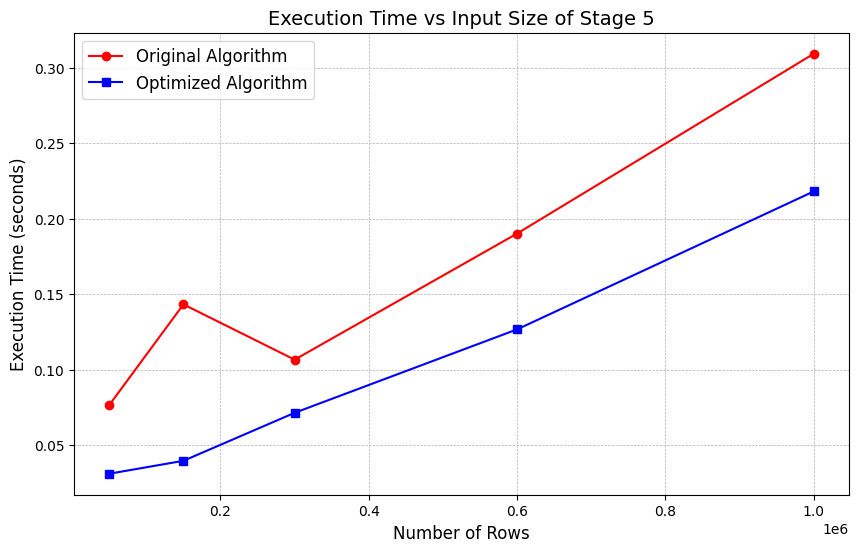

In [113]:
import sys
import os
from contextlib import contextmanager
# Avoid to print all the results again
@contextmanager
def suppress_print():
    saved_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    try:
        yield
    finally:
        sys.stdout.close()
        sys.stdout = saved_stdout

# Dataset sizes to test computational complexity
sizes = [50000, 150000, 300000, 600000, 1000000]

orig_times = []
opt_times = []

for n in sizes:
    sample_df = data_stats.sample(n=n, replace=True).reset_index(drop=True)

    # Original algorithm
    def run_original():
        with suppress_print():
            fisher_discriminant_analysis_ORI(
                data=sample_df,
                group_col="R_category",
                exclude_cols=["ID"]
            )

    # Optimized algorithm
    def run_optimized():
        with suppress_print():
            fisher_discriminant_analysis_OPT(
                data=sample_df,
                group_col="R_category",
                exclude_cols=["ID"]
            )

    orig_time = timeit.timeit(run_original, number=3) / 3
    opt_time = timeit.timeit(run_optimized, number=3) / 3

    orig_times.append(orig_time)
    opt_times.append(opt_time)

# Plot
plt.figure(figsize=(10,6))
plt.plot(sizes, orig_times, marker='o', color='red', label='Original Algorithm')
plt.plot(sizes, opt_times, marker='s', color='blue', label='Optimized Algorithm')

plt.title('Execution Time vs Input Size of Stage 5', fontsize=14)
plt.xlabel('Number of Rows', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

#Algorithm Optimization – Analysis of data separability

This section analyzes the computational complexity of the original Fisher Discriminant Analysis (FDR) algorithm, the optimized version, and compares their execution times.

## Complexity of the Original Algorithm

The original algorithm `fisher_discriminant_analysis_ORI` performs the following main steps:

1. Select numerical columns and calculate class-wise and overall feature means.
2. Compute the within-class scatter matrix (`within-class scatter`) using a loop over each class:
  
  ` within_class_scatter += np.dot((class_data - class_mean).T, (class_data - class_mean))`

This involves subselecting the data for each class in every iteration.

3. Compute the between-class scatter matrix (between-class scatter) using another loop over classes.

4. Calculate the Fisher Discriminant Ratio (FDR) as the diagonal of the resulting matrix.


## Implemented Optimization
The optimized version (fisher_discriminant_analysis_OPT) introduces several improvements:

- Group the data by class once using groupby, avoiding multiple repeated subsets inside loops.

- Use numpy arrays for matrix operations, which are faster than DataFrame operations.

- Keep the scatter matrix calculations but leverage vectorized indexing to reduce overhead.

## Impact on complexity:

- Class-wise data selection no longer traverses the DataFrame multiple times.

- within_class_scatter calculation uses efficient vectorized operations


The theoretical complexity remains the same, but execution time is significantly improved.

## Execution Time Comparison

**Original	2.282478 seconds**
**Optimized	2.169365 seconds**

The optimized version is faster, although the improvement is modest due to the dataset size. On larger datasets or with more classes, the optimization would have a more significant impact.


## Graphical complexity between the algorithms

- The original algorithm shows faster growth in execution time due to multiple operations performed within loops and the use of DataFrame structures within the cycle.

- The optimized algorithm, by vectorizing operations and avoiding recomputations, shows a linear relationship but with a much lower slope.

- This stage is where optimization produces one of the best results in the entire computational pipeline.

## Conclusion - Stage 5

The optimization focused on reducing data subsetting overhead and including vectorized operations. This decreased execution time and makes the algorithm more scalable.

Overall, using good practices in DataFrame manipulation and matrix operations can lead to substantial efficiency gains without affecting the analysis results.

## Overall conclusion


- All optimized algorithms reduce execution time.

- The improvement is moderate in stage 4, but very significant in stages 2 and 5, where vectorization and the reduction of repetitive operations have the greatest impact.

- The growth in time is consistent with O(n) behavior in almost all cases, showing that the functions scale linearly.

- The optimizations generate more visible benefits as the size of the dataset increases, which is key for applications with large volumes of data.